In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from geobr import read_state
import imageio
%matplotlib inline

<AxesSubplot:>

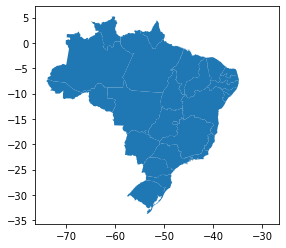

In [2]:
# Gerando shape do brasil dividido em estados com a biblioteca GEOBR
shape_br = read_state(code_state='all')
shape_br.plot()

In [3]:
# Seleciona em 'casos_full.csv' apenas os atributos que vamos trabalhar
data = pd.read_csv('caso_full.csv')
data = data[['epidemiological_week','new_confirmed','new_deaths', 'place_type', 'city_ibge_code','state']]

In [4]:
# Filtra todas informações de estados e agrupa por semana epidemiológica
data_state = data[data['place_type']=='state']
data_state = data_state.groupby(['epidemiological_week', 'state']).max()
data_state

new_confirmed  new_deaths place_type  \
epidemiological_week state                                         
9                    SP                 1           0      state   
10                   BA                 1           0      state   
                     DF                 1           0      state   
                     ES                 1           0      state   
                     RJ                 1           0      state   
...                                   ...         ...        ...   
34                   RS              3210          78      state   
                     SC              2647          44      state   
                     SE               386          16      state   
                     SP              9847         416      state   
                     TO               989          15      state   

                            city_ibge_code  
epidemiological_week state                  
9                    SP               35.0  
10                   BA               29.0  
                     DF               53.0  
                     ES               32.0  
                     RJ               33.0  
...                                    ...  
34                   RS               43.0  
                     SC               42.0  
                     SE               28.0  
                     SP               35.0  
                     TO               17.0  

[644 rows x 4 columns]

In [5]:
# Cria a coluna com o poligono representante de cada estado e adiciona ela ao data_state
states = shape_br[['code_state', 'geometry']]
data_state.reset_index(inplace=True)
data_state = data_state.merge(states,how='inner', left_on='city_ibge_code', right_on='code_state')
data_state = data_state.drop(['city_ibge_code','place_type'], axis=1)
data_state

,epidemiological_week,state,new_confirmed,new_deaths,code_state,geometry
0,9,SP,1,0,35.0,"MULTIPOLYGON (((-44.90215 -23.35392, -44.90650..."
1,10,SP,4,0,35.0,"MULTIPOLYGON (((-44.90215 -23.35392, -44.90650..."
2,11,SP,19,0,35.0,"MULTIPOLYGON (((-44.90215 -23.35392, -44.90650..."
3,12,SP,110,6,35.0,"MULTIPOLYGON (((-44.90215 -23.35392, -44.90650..."
4,13,SP,235,16,35.0,"MULTIPOLYGON (((-44.90215 -23.35392, -44.90650..."
...,...,...,...,...,...,...
639,30,TO,955,11,17.0,"MULTIPOLYGON (((-48.35878 -5.17008, -48.33846 ..."
640,31,TO,1088,13,17.0,"MULTIPOLYGON (((-48.35878 -5.17008, -48.33846 ..."
641,32,TO,1227,13,17.0,"MULTIPOLYGON (((-48.35878 -5.17008, -48.33846 ..."
642,33,TO,1075,13,17.0,"MULTIPOLYGON (((-48.35878 -5.17008, -48.33846 ..."


<ipython-input-6-b9abccd1a4b9>:21: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=j[1], xy=j['coords'], horizontalalignment='center', verticalalignment='center', fontsize=20)
<ipython-input-6-b9abccd1a4b9>:21: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=j[1], xy=j['coords'], horizontalalignment='center', verticalalignment='center', fontsize=20)
<ipython-input-6-b9abccd1a4b9>:21: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=j[1], xy=j['coords'], horizontalalignment='center', verticalalignment='center', fontsize=20)
<ipython-input-6-b9abccd1a4b9>:21: Matpl

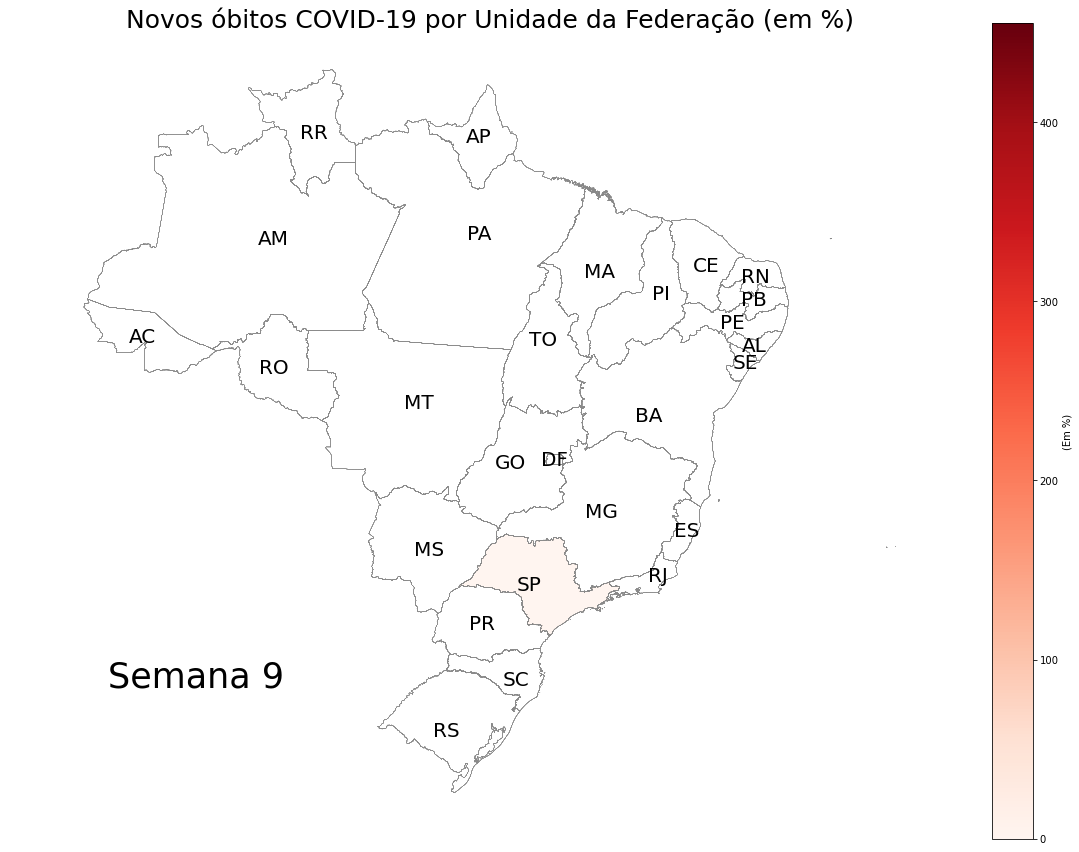

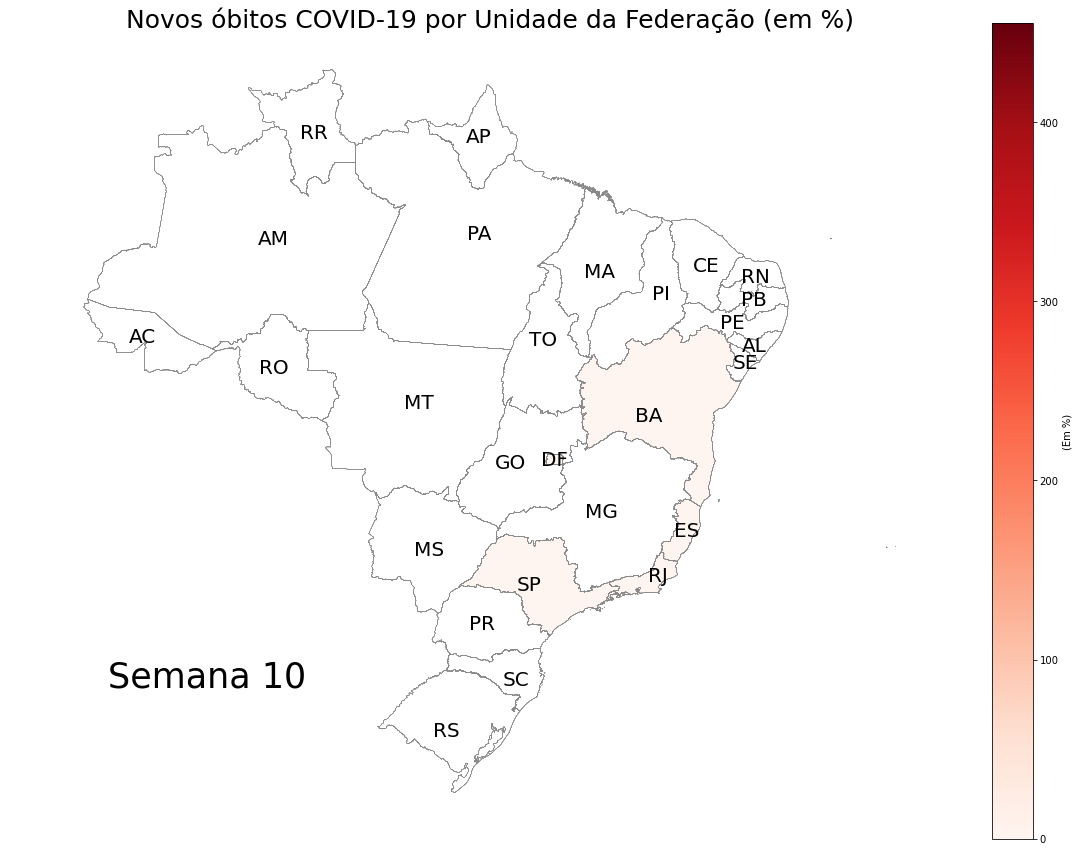

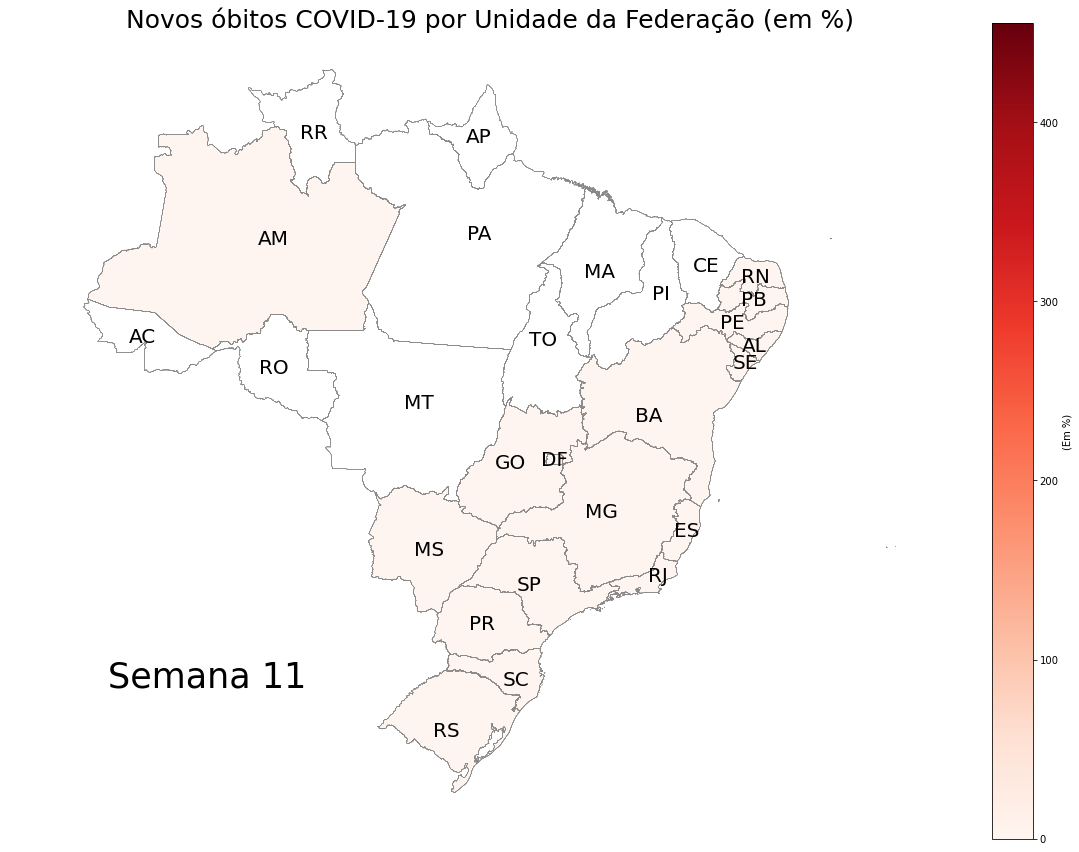

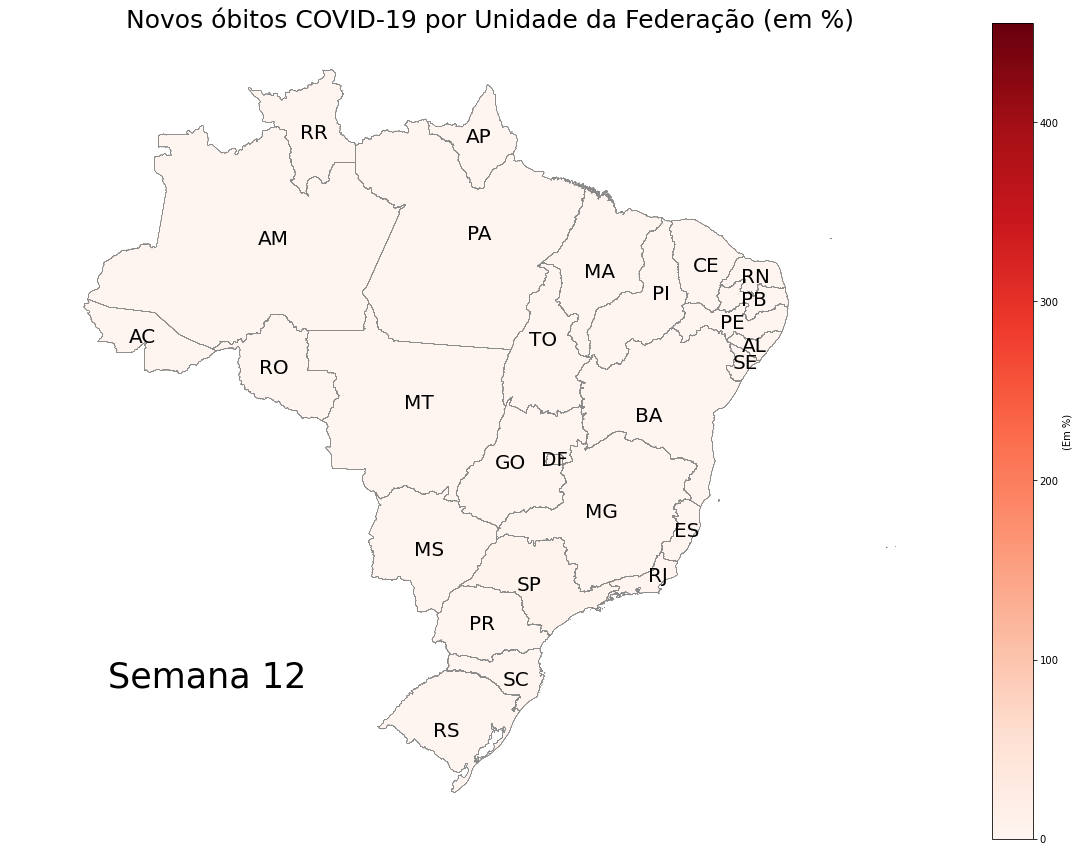

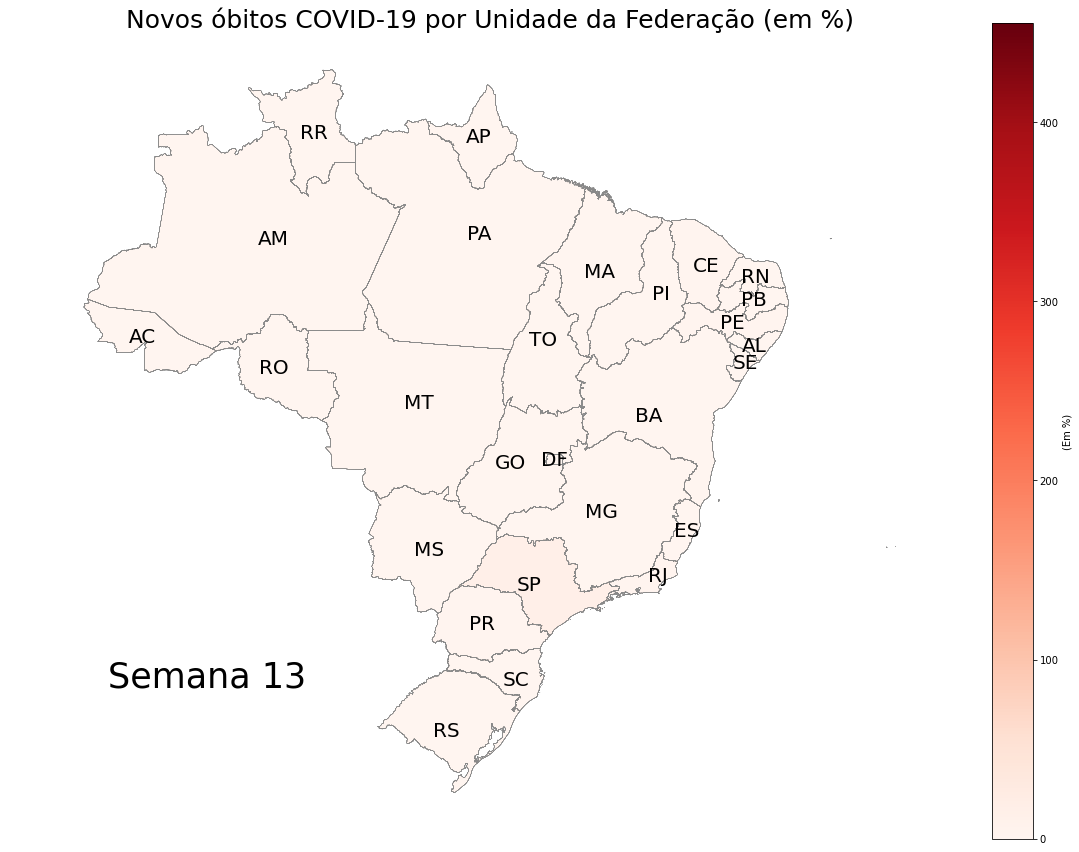

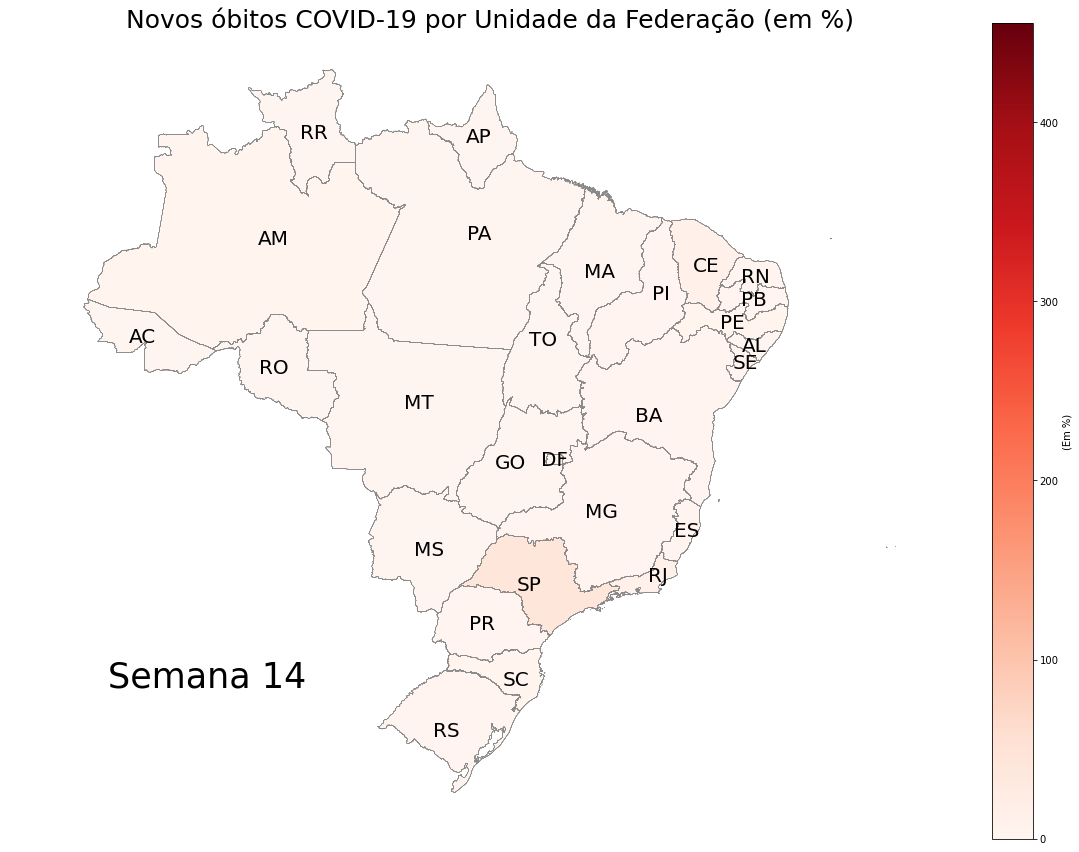

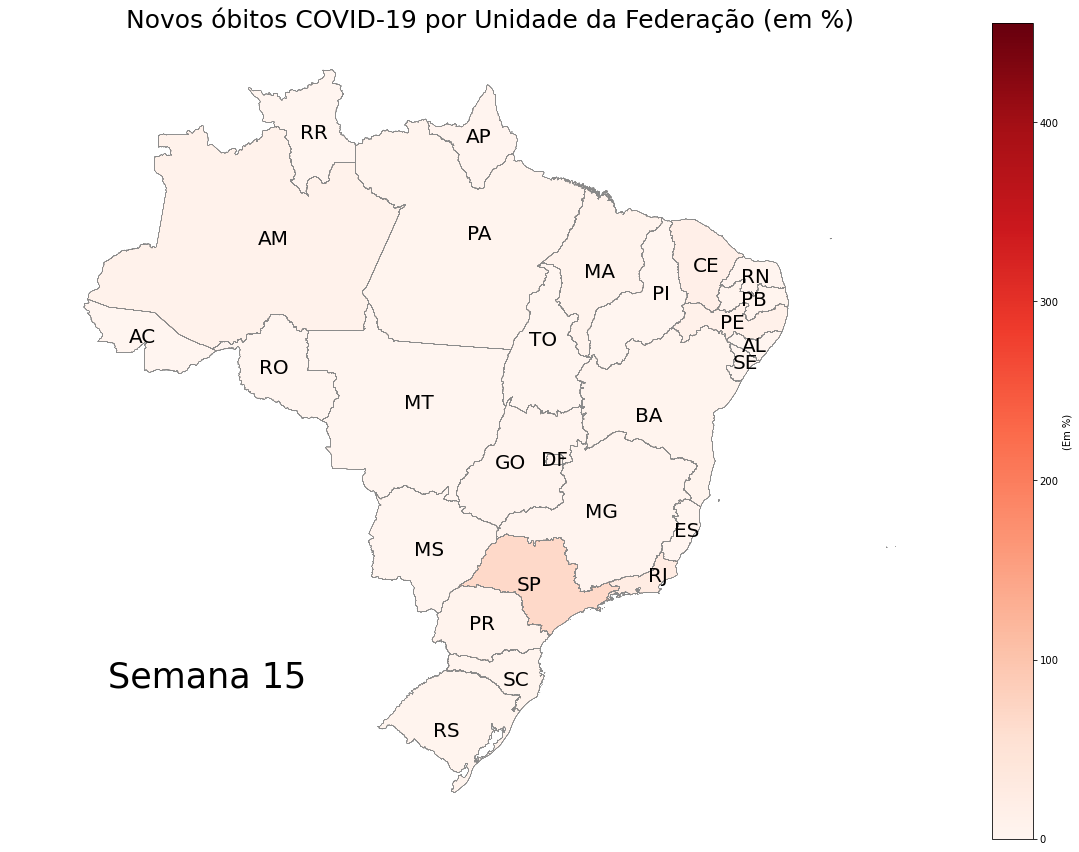

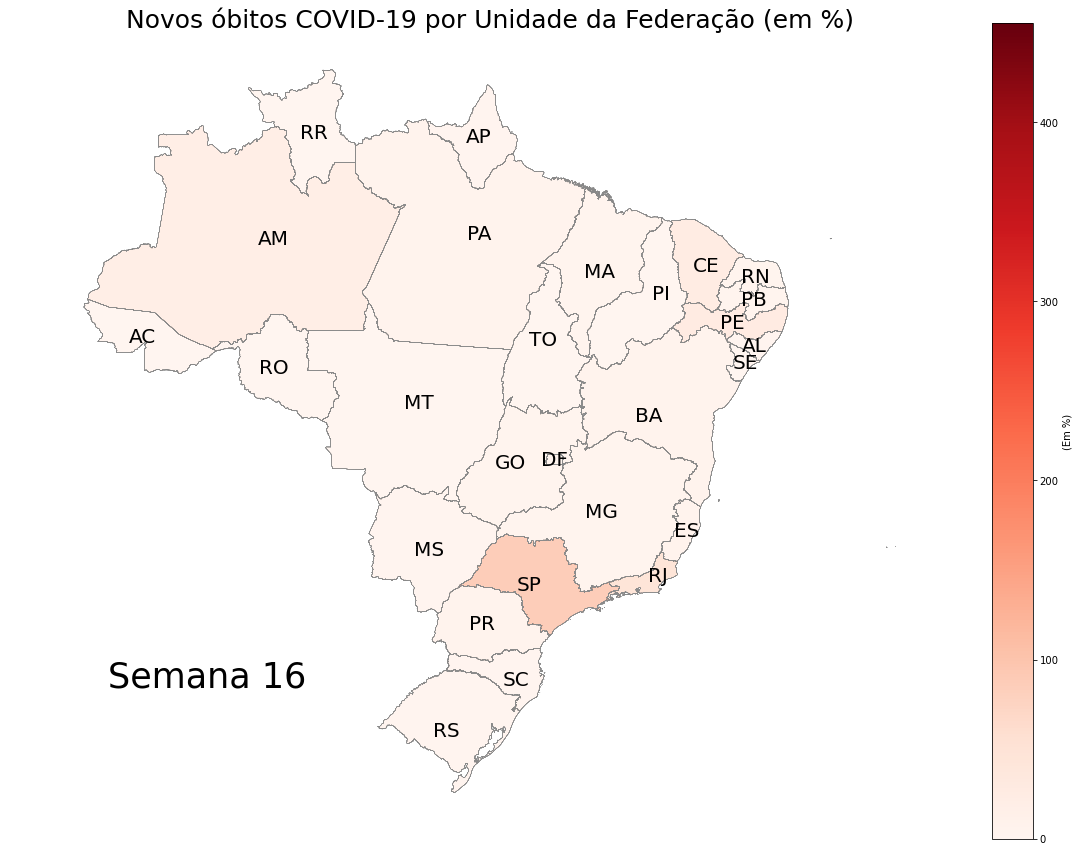

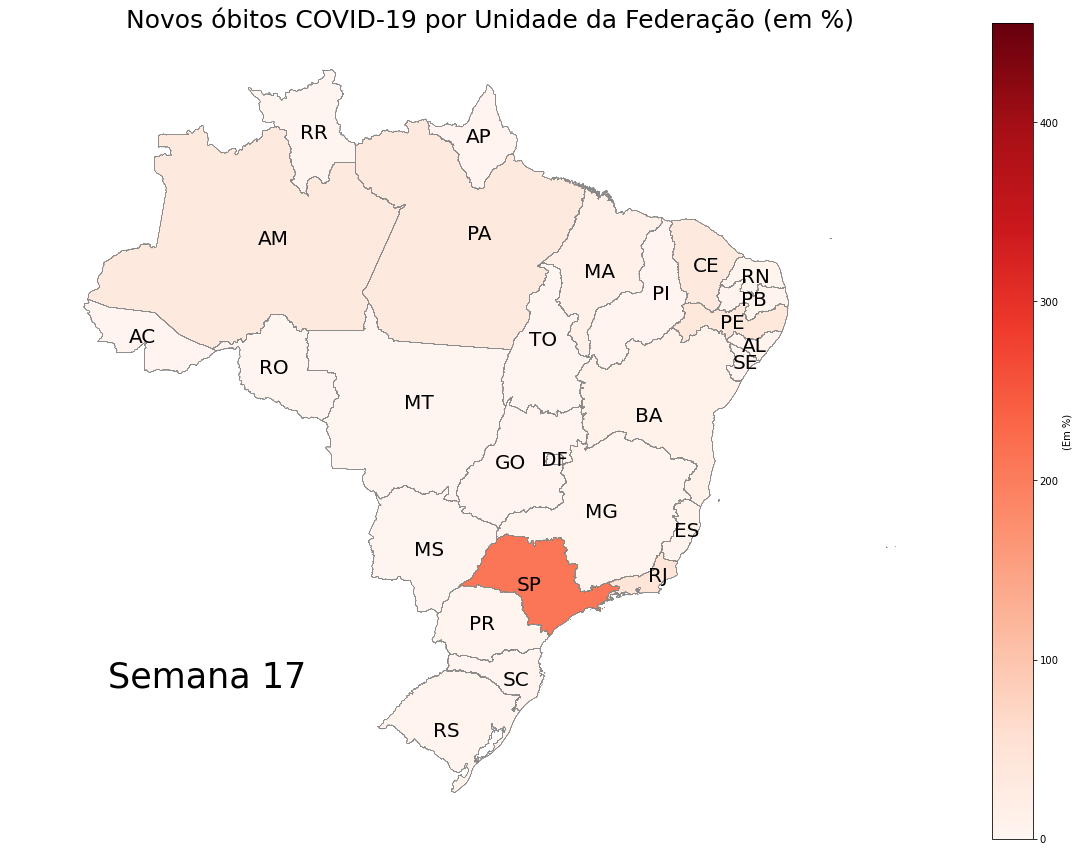

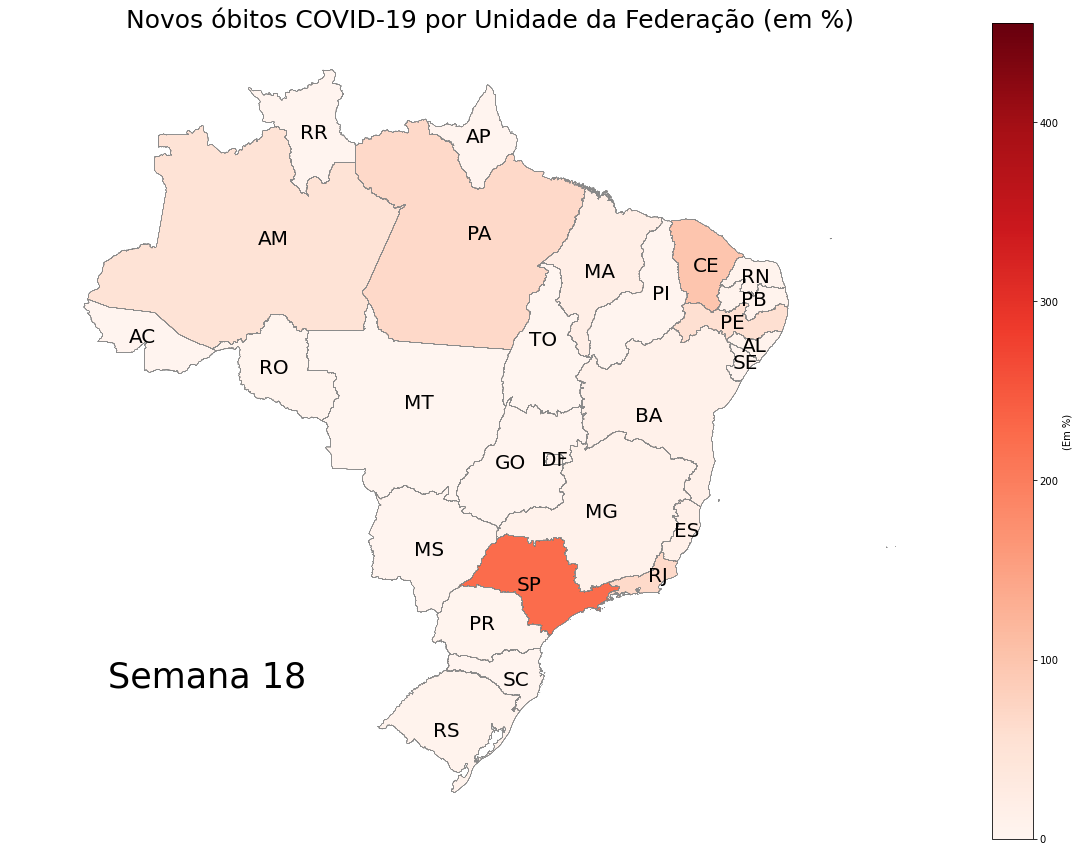

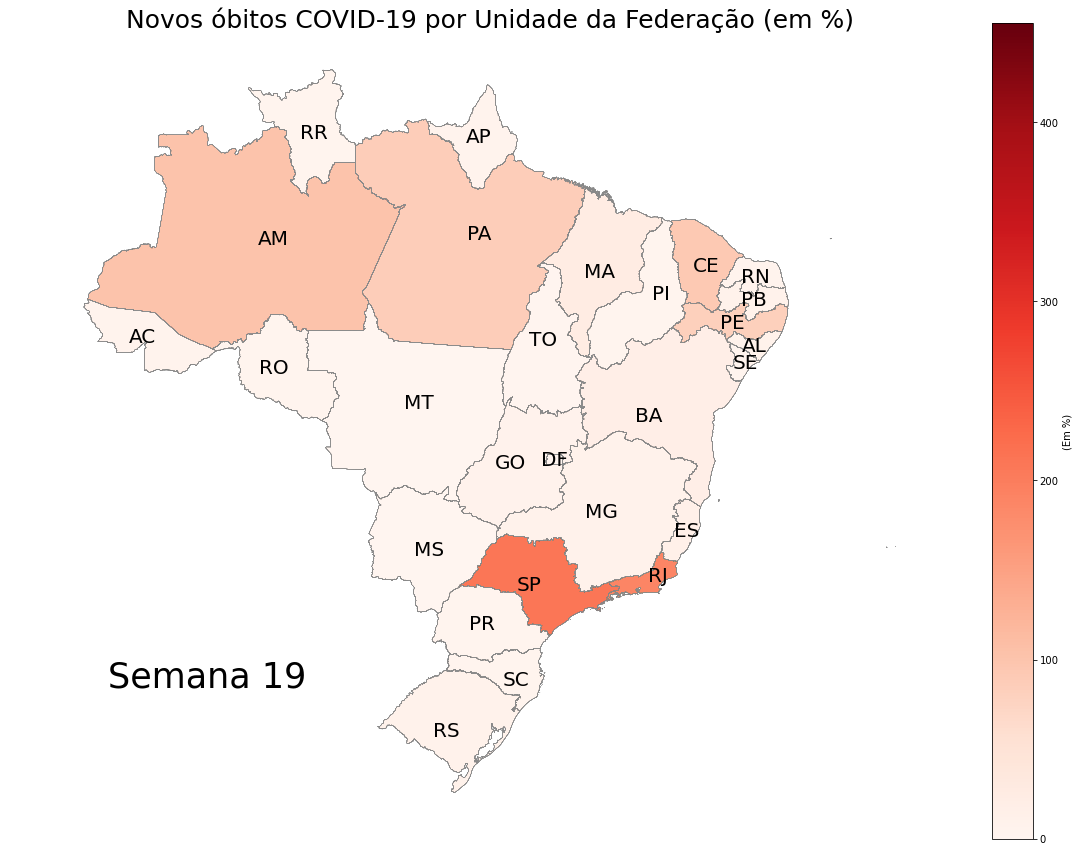

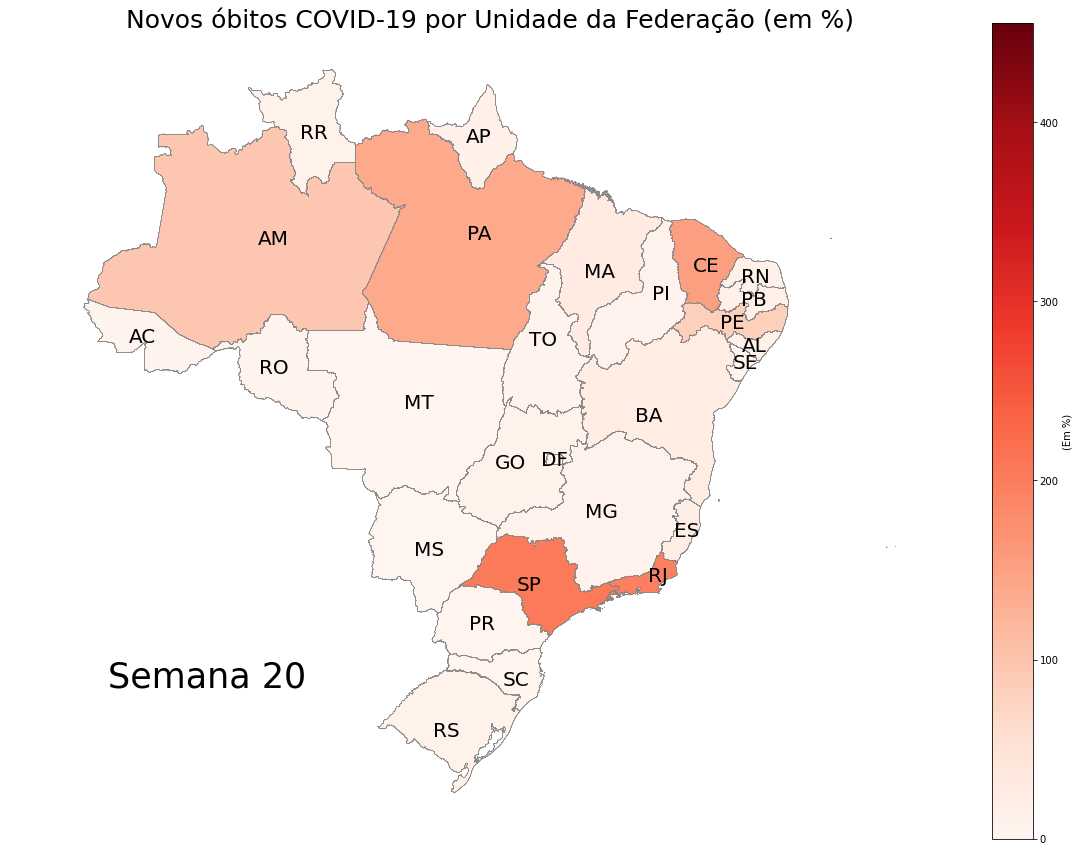

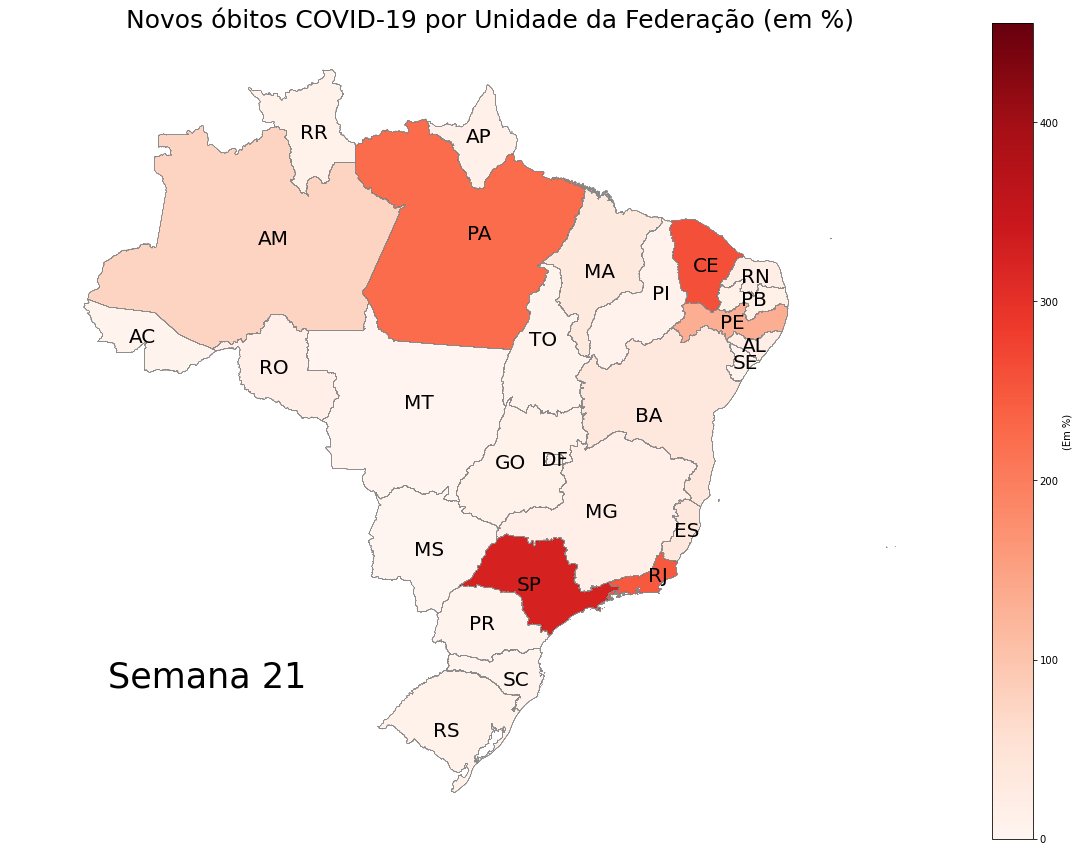

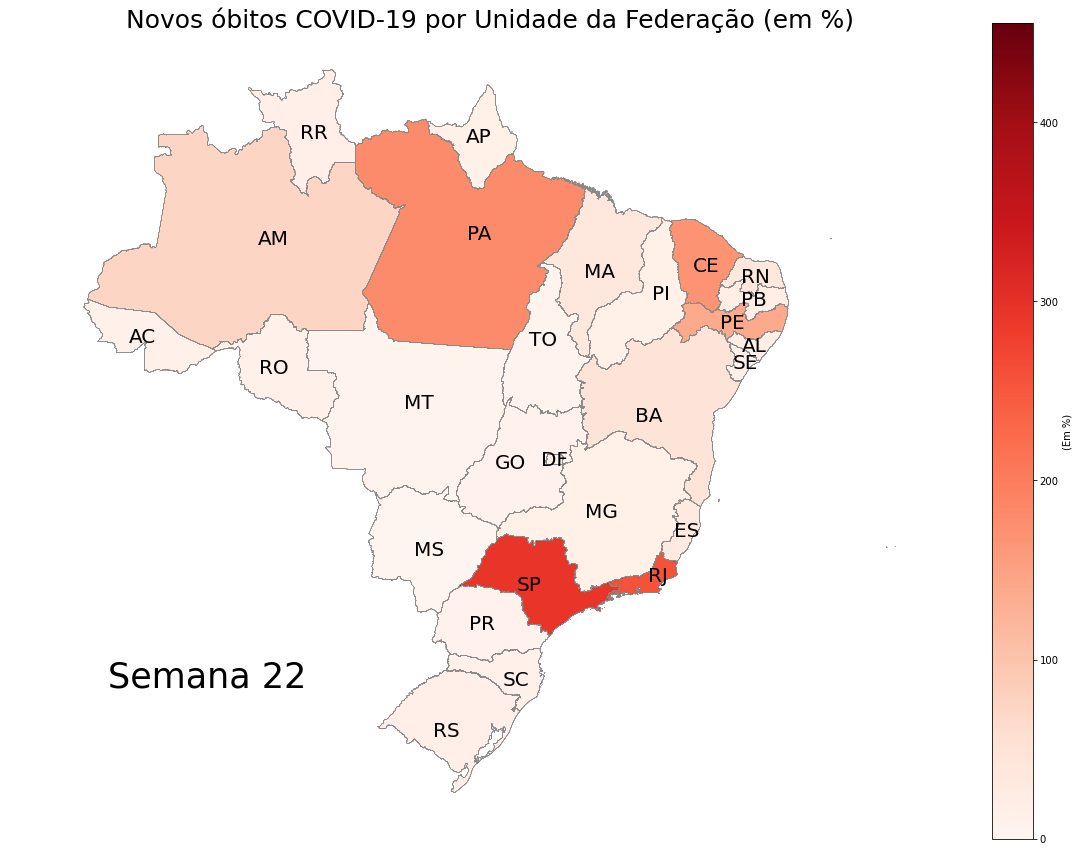

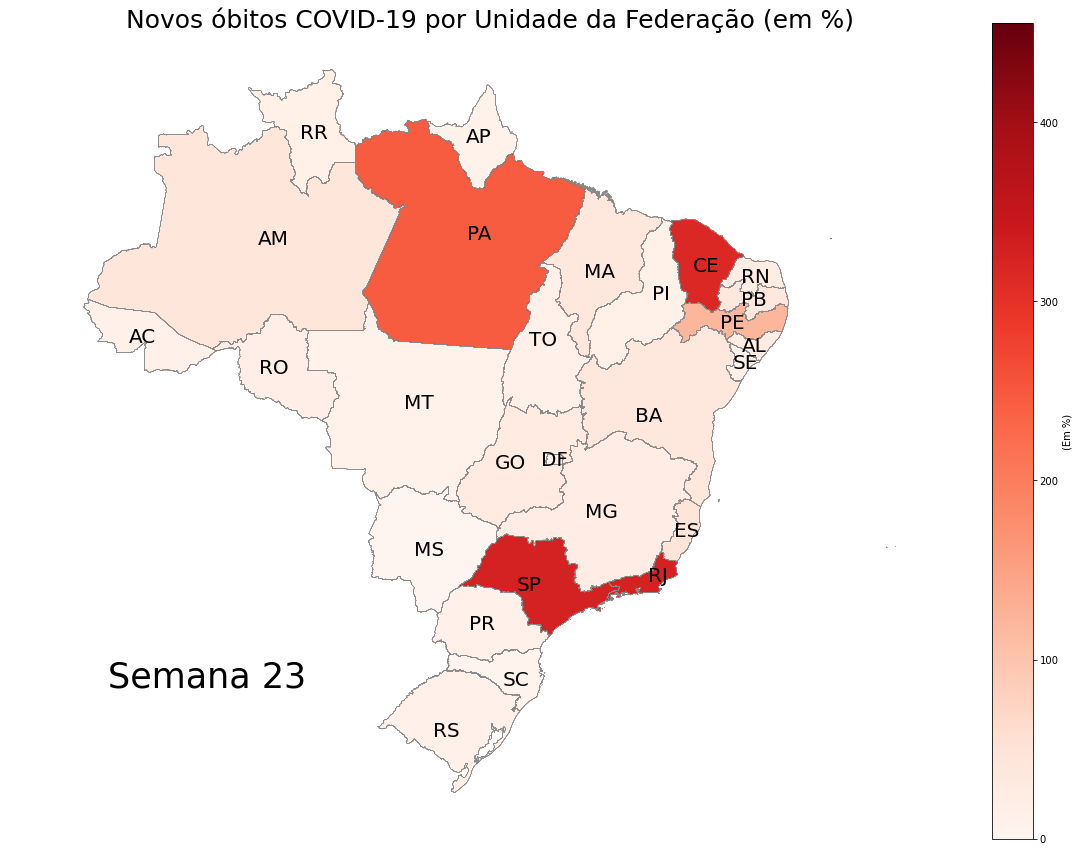

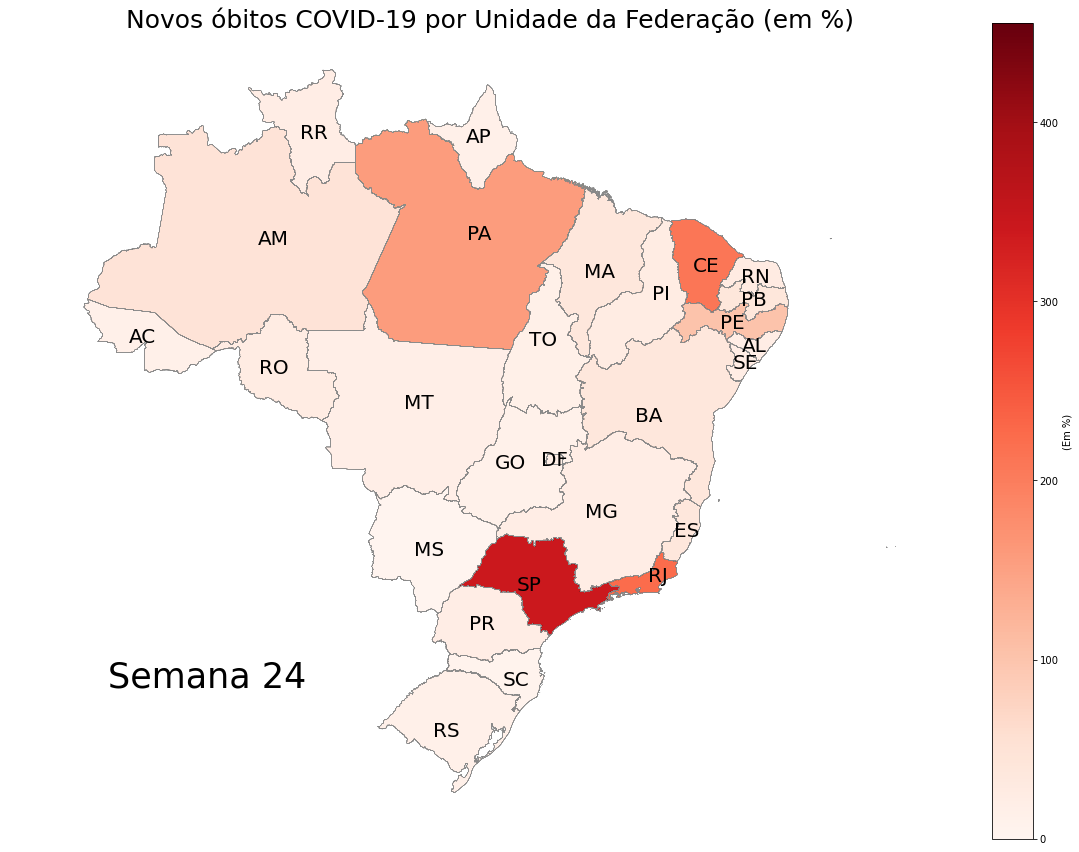

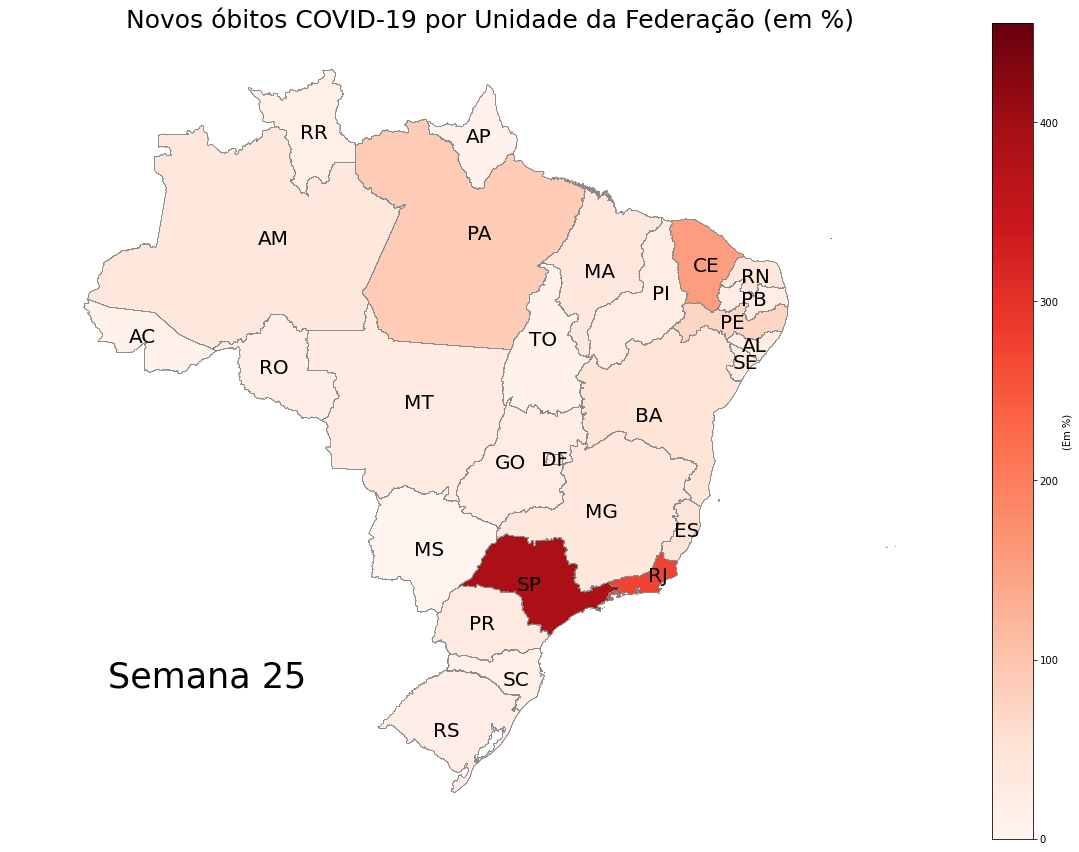

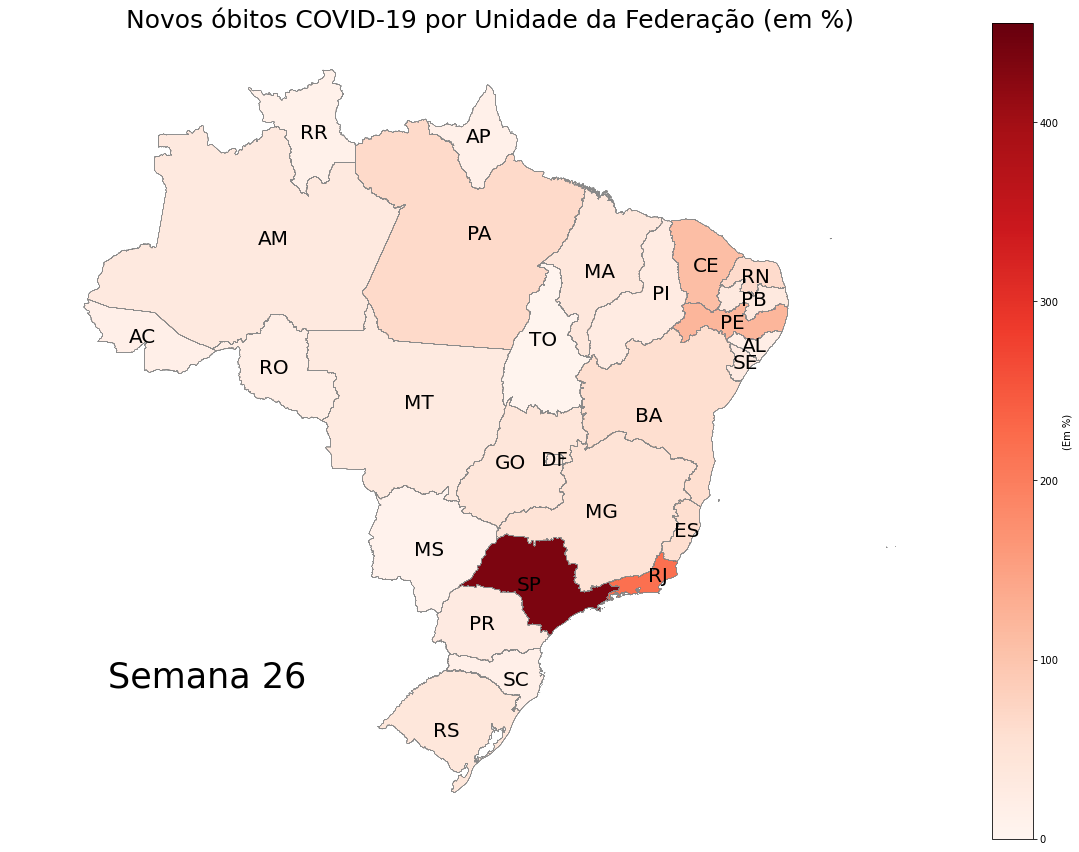

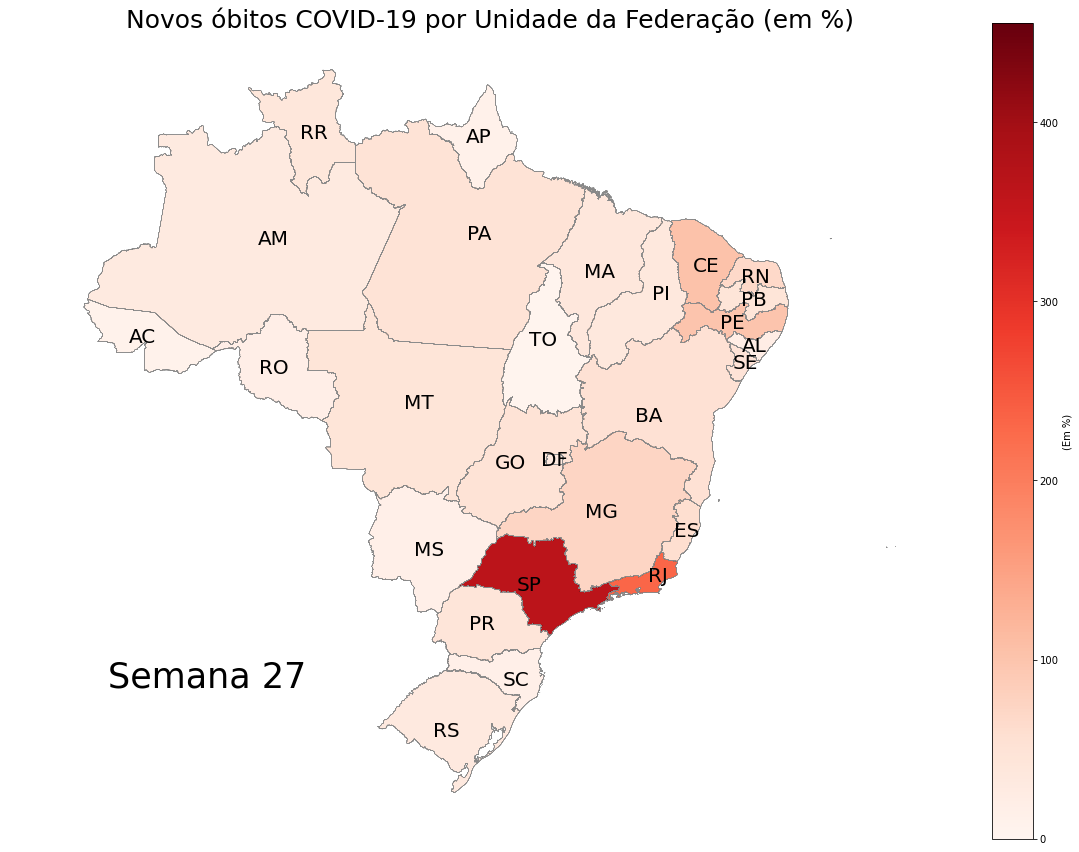

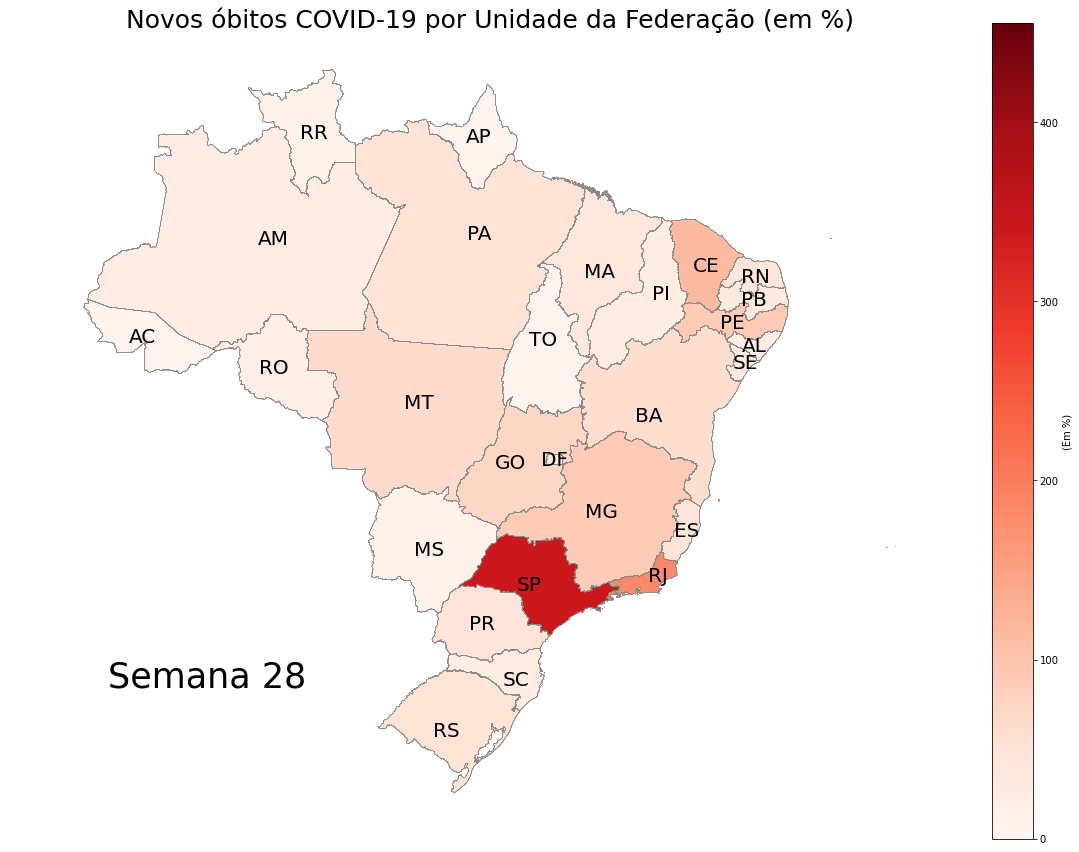

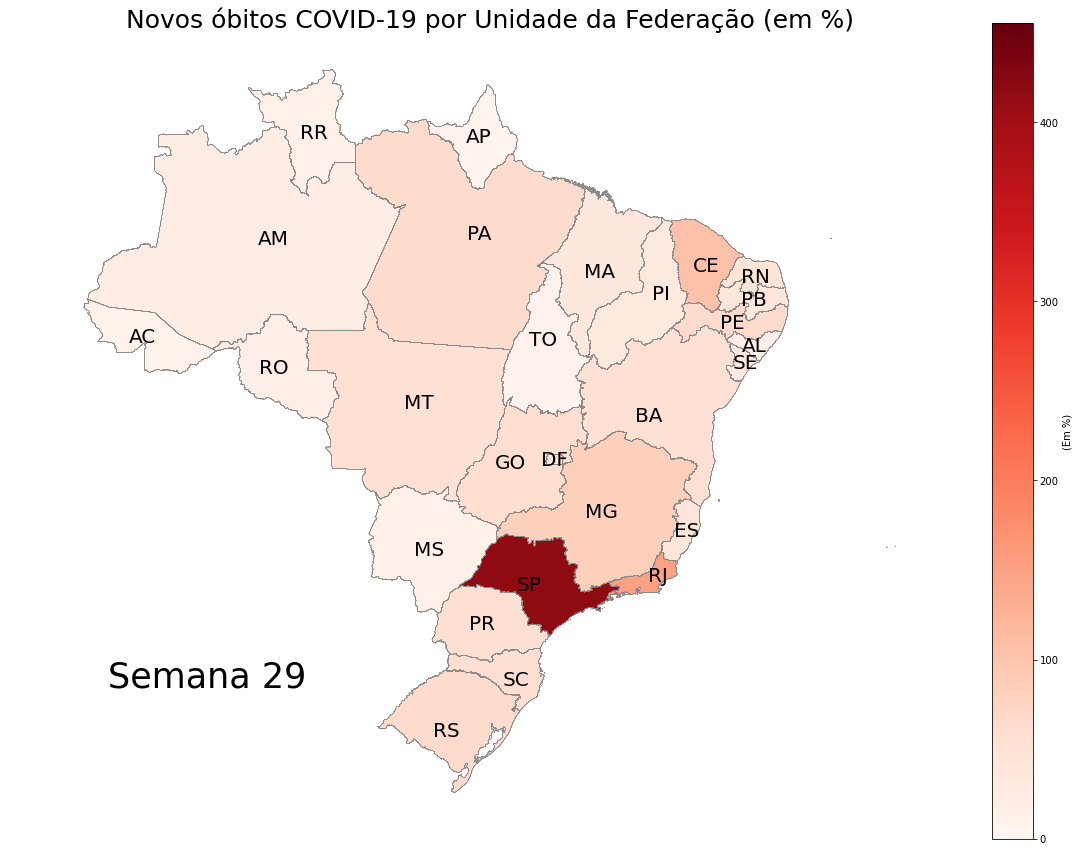

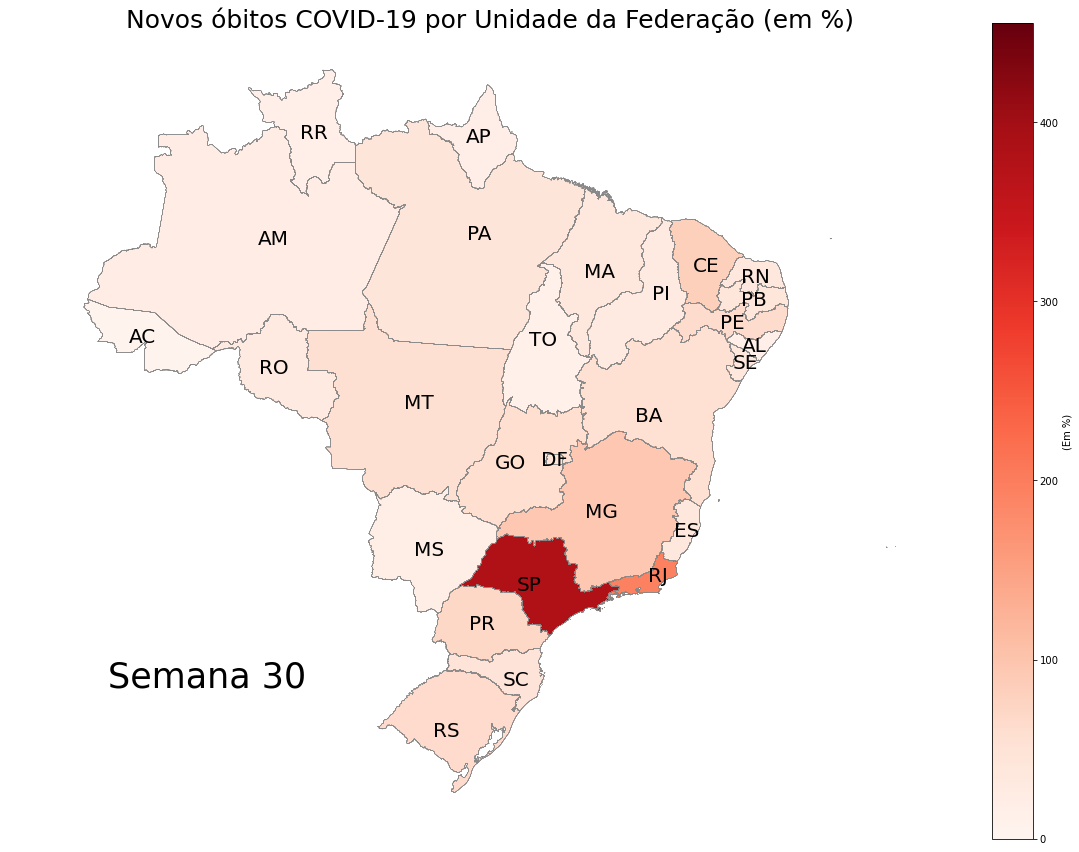

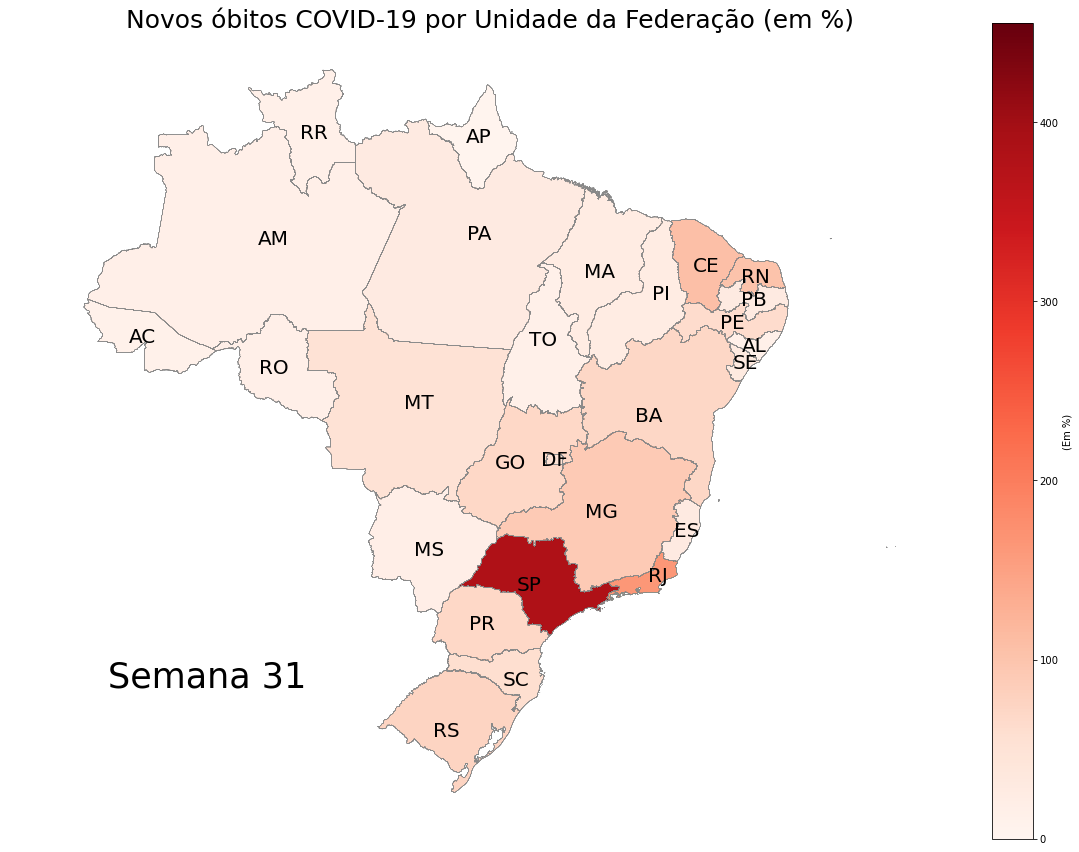

In [6]:
#Faz a plotagem dos mapas por semana epidemiológica 
for semana in range(9,32):
    semana_x = data_state[data_state.epidemiological_week == semana]
    
    #Fazendo o typecasting para GeoDataFrame
    semana_x = gpd.GeoDataFrame(semana_x)
    copy = gpd.GeoDataFrame(data_state)
    copy2 = shape_br
    copy2['coords'] = copy2['geometry'].apply(lambda x: x.representative_point().coords[:])
    copy2['coords'] = [coords[0] for coords in copy2['coords']]
    
    fig, ax = plt.subplots(figsize=(20, 15))
    semana_x.plot(column='new_deaths', cmap='Reds', vmin=0.0, legend=True,legend_kwds={'label': f"(Em %)", 'orientation': "vertical"},vmax=data_state['new_deaths'].max(), ax=ax)
    
    ax.annotate(f'Semana {semana}', xy=(0.1,.225),xycoords='figure fraction',horizontalalignment='left', verticalalignment='top',fontsize=35)
    copy.geometry.boundary.plot(color=None,edgecolor='#888888',linewidth = 0.1,ax=ax)
    ax.set_title(f"Novos óbitos COVID-19 por Unidade da Federação (em %)", fontdict={'fontsize':25})
    ax.axis('off')
    
    for i, j in copy2.iterrows():
        plt.annotate(s=j[1], xy=j['coords'], horizontalalignment='center', verticalalignment='center', fontsize=20)
    #plt.show()
    # Salva cada mapa como um chart
    chart = ax.get_figure()
    chart.savefig(f'novos_obitos_semana_{semana}.png', dpi=120)